In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, accuracy_score
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neighbors import KNeighborsClassifier as KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import precision_recall_curve, average_precision_score
import sqlite3
from sklearn import tree
% matplotlib inline
pd.set_option('display.max_rows', 500)

In [2]:
lm = LinearRegression()
LRCV=LogisticRegressionCV

In [13]:
def age_bin(age):
    value=""
    if pd.isnull(age):
        value="UnknownAge"
    elif age<20:
        value="0-19"
    elif age<46:
        value="20-45"
    else:
        value="46+"
    return value

def cabin_bin(cabin):
    value=""
    if pd.isnull(cabin):
        value="Unknown"
    else:
        value=cabin[0]
    return value

def last_names(name):
    splits=name.split(",")[0]
    splits=splits.replace(",","")
    return splits
def fare_bin(fare):
    value=""
    if fare<10:
        value="Und10"
    if fare<30:
        value="10-30"
    if fare<75:
        value
def ticket_bin(ticket):
    alpha=["ABCDEFGHIJKLMNOPQRSTUVWXYZ"]
    value=""
    if ticket[0] not in alpha:
        value=str(ticket[0])
    else:
        value=ticket[:3]
    return value
def report(max_rand,bestf1,bestx0,prec,recall,f1score,confusion,test,predictions,modelname):
    print classification_report(test,predictions)
    print
    print "Random Iterations: ", max_rand-1
    print "Best f1:  ",max(bestf1)
    print "Best x0:  ",bestx0
    print
    print "Average Precision: ", np.mean(prec)
    print "Average Recall:    ", np.mean(recall)
    print "Average F1-Score:  ", np.mean(f1score)
    print 
    print "Variance Precision:", np.var(prec)
    print "Variance Recall:   ", np.var(recall)
    print "Variance F1-Score: ", np.var(f1score)
    print 
    print "Confusion for",modelname
    print(confusion)

## Pre-Task: Describe the goals of your study

The primary goal of this project is to use logistic regression, and other categorical methods to determine whether each of the passengers of the Titanic either lived or died. The secondary goals of this project are to correctly use dummy variables and to begin learning ML techniques by comparitive study.

## Part 1: Aquire the Data

psql -h dsi.c20gkj5cvu3l.us-east-1.rds.amazonaws.com -p 5432 -U dsi_student titanic
password: gastudents

#### 1. Connect to the remote database

In [4]:
#df=pd.read_csv("train.csv")
import psycopg2
params = {
 'dbname': 'titanic',
 'user': 'dsi_student',
 'password': 'gastudents',
 'host': 'dsi.c20gkj5cvu3l.us-east-1.rds.amazonaws.com',
 'port': 5432
}

conn = psycopg2.connect(**params)
c = conn.cursor()

#### 2. Query the database and aggregate the data

In [5]:
df=pd.read_sql("SELECT * FROM train",con=conn)
copy=df.copy()

#### 5. What are the risks and assumptions of our data? 

The data is not descriptive of the passengers on a personal level, so the results will be limited strictly to the information of the manifest. Thus the key assumption of this data is that all passengers can be described solely by their age, gender, travel class, and whether they are traveling with family members. Thus a large risk of the data is that it is not descriptive enough.

## Part 2: Exploratory Data Analysis

In [6]:
df.head()

,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S
3,3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,None,S


#### 1. Describe the Data

The data is of the passenger manifest of the Titanic during its last voyage. In addition to the manifest information, the data also includes whether or not each passenger survived. 

In [7]:
df.describe()

,index,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,445.000000,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,222.500000,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,445.000000,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,667.500000,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,890.000000,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


#### 2. Visualize the Data

/Users/thomas/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/thomas/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


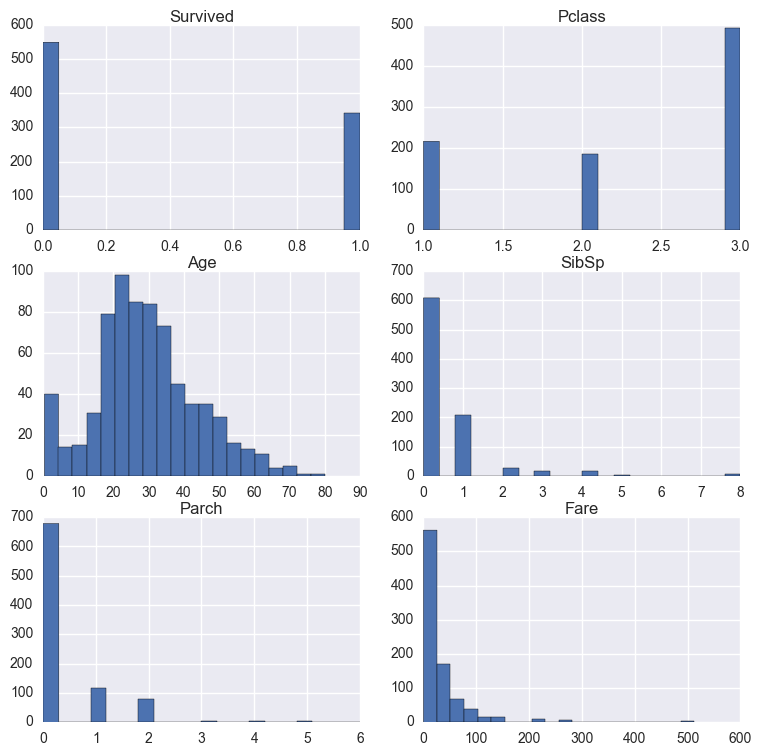

In [8]:
cols=['Survived','Pclass','Age','SibSp','Parch','Fare']
figure,axes=plt.subplots(3,2,figsize=(9,9))
i=1
for col in cols:
    plt.subplot(3,2,i)
    plt.hist(df[col],range=(min(df[col]),max(df[col])),bins=20)
    plt.title(col,y=0.98)
    i+=1
plt.show()

#### Notes on the data visualization
It looks like a few of the columns are logarithmic in nature, so it would be logical to normalize those logarithmic columns. However, the only column that needs to be normalized is 'Fare'. This is because Fare is the only continuous logarithmic column, so it is the only column that a log normalization will have an affect on. That is, becasue SibSp and Parch are discretely binned, a normalization would just shift bins to being at a different value. And because discrete bins would be substituted with dummy variables, the normalization would be pointless.

## Part 3: Data Wrangling

#### 1. Create Dummy Variables for *Sex* 

In [9]:
copy=df.copy()
copy["Survived"]=copy["Survived"].apply(lambda x: "Alive" if x==1 else "Dead")
copy["Fare"]=copy["Fare"].apply(lambda x: x+3) #We add a value to each of the values because some people paid no fare
                    #and log(0) is non-finite, which is something we cannot have. The number 3 might seem arbitrary,
                    #but it was selected because it created the best bin diversity
copy["Fare"]=copy["Fare"].apply(lambda x: np.log(x))
#copy["Fare"]=copy["Fare"].apply(lambda x: round(x))

regression_df=copy
regression_df["Pclass"]=regression_df["Pclass"].apply(lambda x: str(x))
regression_df["Age"]=regression_df["Age"].apply(lambda x: age_bin(x))
regression_df["Name"]=regression_df["Name"].apply(lambda x: last_names(x))
regression_df["Cabin"]=regression_df["Cabin"].apply(lambda x: cabin_bin(x))
regression_df["Ticket"]=regression_df["Ticket"].apply(lambda x: ticket_bin(x))
regression_df["Pclass-Sex"]=regression_df["Pclass"]+regression_df["Sex"]
regression_df["Age-Sex"]=regression_df["Age"]+regression_df["Sex"]
#regression_df["Pclass-Embarked"]=regression_df["Pclass"]+regression_df["Embarked"]

target=regression_df["Survived"].copy()
temp1=regression_df.copy()
temp2=regression_df.copy()
delete1=["Name","Ticket","index","PassengerId","Survived","Sex","Cabin","Age","Pclass","Parch",
        "Age-Sex","Fare"]#SibSp is not in this delete list
delete2=["Name","Ticket","index","PassengerId","Survived","Sex","Cabin","Age","Pclass","Parch",
        "Embarked","Pclass-Sex"]
for x in delete1:
    del temp1[x]
for x in delete2:
    del temp2[x]
temp1=pd.get_dummies(temp1,columns=["Pclass-Sex","Embarked"])
temp2=pd.get_dummies(temp2,columns=["Age-Sex"])
delete1=["Pclass-Sex_1female","Embarked_S"]
delete2=["Age-Sex_0-19female"]
for x in delete1:
    del temp1[x]
for x in delete2:
    del temp2[x]

In [10]:
regression_df.groupby(["Age","Sex","Survived"])["Age"].count().to_frame()

Age
Age        Sex    Survived     
0-19       female Alive      53
                  Dead       22
           male   Alive      26
                  Dead       63
20-45      female Alive     118
                  Dead       38
           male   Alive      55
                  Dead      238
46+        female Alive      26
                  Dead        4
           male   Alive      12
                  Dead       59
UnknownAge female Alive      36
                  Dead       17
           male   Alive      16
                  Dead      108

## Part 4: Logistic Regression and Model Validation

#### 1. Define the variables that we will use in our classification analysis

Saved as the 'temp1' and 'temp2' (See Part 3)

#### 2. Transform "Y" into a 1-Dimensional Array for SciKit-Learn

Saved as target (See Part 3)

#### 3. Conduct the logistic regression

Probability Tweaking does not work on a non-regularized regression. This is because a regression always chooses the best outcome.

In [14]:
###Probability Tweaked (Demonstration)

p_tweak=np.linspace(-.2,.2,41)
best_prob=0.
bestf1=0.
for prob in p_tweak:
    x_train,x_test,y_train,y_test=train_test_split(temp1,target,random_state=1)
    logreg=LogisticRegressionCV(cv=5)
    cv_model=logreg.fit(x_train,y_train)
    cv_proba=cv_model.predict_proba(x_test)
    cv_pred=[]
    for conf in cv_proba:
        if conf[0]+prob>0.5:
            cv_pred.append("Alive")
        else:
            cv_pred.append("Dead")

    if float(classification_report(y_test,cv_pred)[-15:-11])>bestf1:
        bestf1=float(classification_report(y_test,cv_pred)[-15:-11])
        best_prob=prob
        
prob=best_prob
x_train,x_test,y_train,y_test=train_test_split(temp1,target,random_state=1)
logreg=LogisticRegressionCV()
cv_model=logreg.fit(x_train,y_train)
cv_proba=cv_model.predict_proba(x_test)
cv_pred=[]
for conf in cv_proba:
    if conf[0]+prob>0.5:
        cv_pred.append("Alive")
    else:
        cv_pred.append("Dead")    
conmat = np.array(confusion_matrix(y_test, cv_pred))
confusion = pd.DataFrame(conmat, index=cv_model.classes_, columns=cv_model.classes_)  
print "Best prob: ",best_prob
print  "Using Pclass-Sex Dummies \n"
print(confusion)
print classification_report(y_test,cv_pred, target_names=["Dead","Alive"])
print "\n"

Best prob:  0.04
Using Pclass-Sex Dummies 

       Alive  Dead
Alive     55    40
Dead      13   115
             precision    recall  f1-score   support

       Dead       0.81      0.58      0.67        95
      Alive       0.74      0.90      0.81       128

avg / total       0.77      0.76      0.75       223





In [15]:
###NOTE, WE ARE ONLY USING RANDOM_STATE=1; WE ARE NOT AVERAGING LIKE WE WILL DO BELOW

x_train1,x_test1,y_train1,y_test1=train_test_split(temp1,target,random_state=1)
logreg=LogisticRegressionCV(cv=5)
cv_model1=logreg.fit(x_train1,y_train1)
cv_pred1=cv_model1.predict(x_test1)
conmat1 = np.array(confusion_matrix(y_test1, cv_pred1))
confusion1 = pd.DataFrame(conmat1, index=cv_model1.classes_, columns=cv_model1.classes_)    
originalconf1=confusion1
logregy_test1=y_test1

The upper limit of coefficient correlation is set at 0.4. Thus, the coefficients we are using show independence.

In [17]:
def color(x):
    color="Lime"
    if np.abs(x)>0.4:
        color="Red"
    return 'background-color: %s' %color

temp1.corr().style.applymap(color)

In [ ]:
###NOTE, WE ARE ONLY USING RANDOM_STATE=1; WE ARE NOT AVERAGING LIKE WE WILL DO BELOW

x_train2,x_test2,y_train2,y_test2=train_test_split(temp2,target,random_state=1)
logreg=LogisticRegressionCV(cv=5)
cv_model2=logreg.fit(x_train2,y_train2)
cv_pred2=cv_model2.predict(x_test2)
conmat2 = np.array(confusion_matrix(y_test2, cv_pred2))
confusion2 = pd.DataFrame(conmat2, index=cv_model2.classes_, columns=cv_model2.classes_)    
logregy_test2=y_test2

Again, the upper limit of coefficient correlation is set at 0.4. Thus, again, the coefficients we are using show independence.

In [ ]:
def color(x):
    color="Lime"
    if np.abs(x)>0.4:
        color="Red"
    return 'background-color: %s' %color

temp2.corr().style.applymap(color)

#### 4. Examine the coefficients to see our correlations

My apologies if I did this in the step before; I was not sure what was meant by this question. The question could have either meant the correlations between the independent variables with eachother, or the independent variables with the dependent variable.

In [ ]:
coef1=pd.DataFrame([x_train1.columns,cv_model1.coef_[0]])
coef1=coef1.T
coef1.columns=["Coefficient","Value"]
coef1

In [ ]:
coef2=pd.DataFrame([x_train2.columns,cv_model2.coef_[0]])
coef2=coef2.T
coef2.columns=["Coefficient","Value"]
coef2

#### 6. Test the Model by introducing a *Test* or *Validaton* set 

Done above.

#### 7. Predict the class labels for the *Test* set

In [ ]:
cv_pred1

In [ ]:
cv_pred2

#### 8. Predict the class probabilities for the *Test* set

In [ ]:
cv_proba1=cv_model1.predict_proba(x_test1)
cv_proba1

In [ ]:
cv_proba2=cv_model2.predict_proba(x_test2)
cv_proba2

#### 9. Evaluate the *Test* set

In [ ]:
print "----------------------------------------------------- \n"
print  "Using 'Pclass-Sex' Dummies and 'SibSp': \n"
print(confusion1),"\n"
print classification_report(y_test1,cv_pred1, target_names=["Dead","Alive"])
print "----------------------------------------------------- \n"
print  "Using 'Age-Sex' Dummies: \n"
print(confusion2),"\n"
print classification_report(y_test2,cv_pred2, target_names=["Dead","Alive"])
print "-----------------------------------------------------"

#### 10. Cross validate the test set

In [ ]:
print "Average Cross-Val Score Model-1:",np.mean(cross_val_score(cv_model1,x_test1,y_test1,cv=5))
print "Average Cross-Val Score Model-2:",np.mean(cross_val_score(cv_model2,x_test2,y_test2,cv=5))

#### 11. Check the Classification Report

In [ ]:
print "----------------------------------------------------- \n"
print  "Using 'Pclass-Sex' Dummies and 'SibSp' \n"
print classification_report(y_test1,cv_pred1, target_names=["Dead","Alive"])
print "----------------------------------------------------- \n"
print  "Using 'Age-Sex' Dummies \n"
print classification_report(y_test2,cv_pred2, target_names=["Dead","Alive"])
print "-----------------------------------------------------"

#### 12. What do the classification metrics tell us?

It states the precision, recall, and f1 scores for the Dead and Alive bins. Furthermore, the support column states how many names are in each bin. I like to use the f1-score as a basis for the predictive power of a logistic regression. The closer to 1.0 it is, the more accurate the regression is. What makes the classification report so useful is that it breaks down the categorical accuracy of the model in an intuitive way.

#### 13. Check the Confusion Matrix

In [ ]:
print(confusion1)
print confusion2

#### 14. What does the Confusion Matrix tell us? 

The confusion matrix matches the predicted values with the actual values. From this, the precision, recall, and f1-scores can be determined. More importantly though, the confusion matrix is a more intuitive approach to our results.

#### 15. Plot the ROC curve

Model-1 corresponds uses 'Pclass-Sex' Dummies and 'SibSp' 

Model-2 corresponds uses 'Age-Sex' Dummies 

In [ ]:
for j in [1]:

    FPR, TPR, _ = roc_curve(y_test1, [i[1] for i in cv_proba1], pos_label=logreg.classes_[j])
    ROC_AUC = auc(FPR, TPR)

    amounts = logreg.classes_
    title = "ROC of Model-1".format(amounts[0], amounts[1])

    plt.figure(figsize=[5,4])
    plt.plot(FPR, TPR, label='ROC curve (area = %0.2f)' % ROC_AUC, linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title(title, fontsize=18)
    plt.legend(loc="lower right")
    plt.show()
    
for j in [1]:

    FPR, TPR, _ = roc_curve(y_test2, [i[1] for i in cv_proba2], pos_label=logreg.classes_[j])
    ROC_AUC = auc(FPR, TPR)

    amounts = logreg.classes_
    title = "ROC of Model-2".format(amounts[0], amounts[1])

    plt.figure(figsize=[5,4])
    plt.plot(FPR, TPR, label='ROC curve (area = %0.2f)' % ROC_AUC, linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title(title, fontsize=18)
    plt.legend(loc="lower right")
    plt.show()

#### 16. What does the ROC curve tell us?

The ROC curve tells us the relationship between correctly predicting and incorrectly predicting whether someone is alive or dead. The curve is plotted by organizing the confidence scores of a model, and then plotting the true vs false predictions at different confidence levels. In some scenarios, one would want to maximize the AUC, but I prefer to go with maximizing the f1-score for this case.

## Part 5: Gridsearch

#### 1. Use GridSearchCV with logistic regression to search for optimal parameters 

- Use the provided parameter grid. Feel free to add if you like (such as n_jobs).
- Use 5-fold cross-validation.

On a side-note, the values I used in the gridsearch above created a stronger f1 score than the parameters below. I have provided those parameters from above directly below this cell.

In [ ]:
###THIS IS FOR TEMP1 (GRIDSEARCH CELL)

bestx0=0.
bestx1=0.
bestx2=0.
bestf1=0.
max_rand=4
curr_f1=[]

for x0_change in np.linspace(-.15,0.15,7):
    curr_f1=[]
    for random in range(1,max_rand):
        x_train,x_test,y_train,y_test=train_test_split(temp1,target,
                                                       stratify=target,random_state=random)
        logreg = LogisticRegression(solver='liblinear') #'newton-cg', 'lbfgs', 'liblinear', 'sag'
        C_vals = np.linspace(0.0000001,1.1,25)
        penalties = ['l1','l2']

        gs = GridSearchCV(logreg, {'penalty': penalties, 'C': C_vals}, cv=5)
        gs.fit(x_train, y_train)

        logreg = LogisticRegression(C=gs.best_params_['C'], penalty=gs.best_params_['penalty'])
        cv_model = logreg.fit(x_train, y_train)
        cv_pred = cv_model.predict(x_test)

        prob = cv_model.predict_proba(x_test)
        conmat = np.array(confusion_matrix(y_test, cv_pred))
        confusion = pd.DataFrame(conmat, index=cv_model.classes_, columns=cv_model.classes_)      
        conmat = np.array(confusion_matrix(y_test, cv_pred))
        confusion = pd.DataFrame(conmat, index=cv_model.classes_, columns=cv_model.classes_)      
        pred=[]
        x0_change=bestx0
        for x in prob.T[0]:
            if (x+x0_change)>(0.5):
                pred.append(cv_model.classes_[0])
            else:
                pred.append(cv_model.classes_[1])
        cv_pred=pred

        """ Check your performance so far."""

        conmat = np.array(confusion_matrix(y_test, cv_pred))
        confusion = pd.DataFrame(conmat, index=cv_model.classes_, columns=cv_model.classes_)
        curr_f1.append(float(classification_report(y_test,cv_pred)[-15:-11]))
    if np.mean(curr_f1)>bestf1:
        bestf1=np.mean(curr_f1)
        bestx0=x0_change

In [ ]:
###THIS IS FOR TEMP1 (REGRESSION CELL)

prec=[]
recall=[]
f1score=[]
bestf1=[]
max_rand=16

for random in range(1,max_rand):
    x_train,x_test,y_train,y_test=train_test_split(temp1,target,test_size=.33,stratify=target,
                                                   random_state=random)
    logreg = LogisticRegression(solver='liblinear') #'newton-cg', 'lbfgs', 'liblinear', 'sag'
    C_vals = np.linspace(0.0000001,1.1,25)
    penalties = ['l1','l2']

    gs = GridSearchCV(logreg, {'penalty': penalties, 'C': C_vals}, cv=5)
    gs.fit(x_train, y_train)

    logreg = LogisticRegression(C=gs.best_params_['C'], penalty=gs.best_params_['penalty'])
    cv_model = logreg.fit(x_train, y_train)
    cv_pred = cv_model.predict(x_test)
    prob = cv_model.predict_proba(x_test)
    conmat = np.array(confusion_matrix(y_test, cv_pred))
    confusion = pd.DataFrame(conmat, index=cv_model.classes_, columns=cv_model.classes_)      
    conmat = np.array(confusion_matrix(y_test, cv_pred))
    confusion = pd.DataFrame(conmat, index=cv_model.classes_, columns=cv_model.classes_)      
    pred=[]
    x0_change=bestx0
    for x in prob.T[0]:
        if (x+x0_change)>(0.5):
            pred.append(cv_model.classes_[0])
        else:
            pred.append(cv_model.classes_[1])
    cv_pred=pred

    """ Check your performance so far."""

    conmat = np.array(confusion_matrix(y_test, cv_pred))
    confusion = pd.DataFrame(conmat, index=cv_model.classes_, columns=cv_model.classes_)      
    
    prec.append(float(classification_report(y_test,cv_pred)[-35:-31]))
    recall.append(float(classification_report(y_test,cv_pred)[-25:-21]))
    f1score.append(float(classification_report(y_test,cv_pred)[-15:-11]))
    bestf1.append(float(classification_report(y_test,cv_pred)[-15:-11]))



In [ ]:
print gs.best_params_

In [ ]:
###TEMP1 PRINT CELL
report(max_rand,bestf1,bestx0,prec,recall,f1score,confusion,y_test,cv_pred,"LogReg Model-1")

In [ ]:
###THIS IS FOR TEMP2 (GRIDSEARCH CELL)

bestx0=0.
bestx1=0.
bestx2=0.
bestf1=0.
max_rand=4
curr_f1=[]

for x0_change in np.linspace(-.15,0.15,7):
    curr_f1=[]
    for random in range(1,max_rand):
        x_train,x_test,y_train,y_test=train_test_split(temp2,target,
                                                       stratify=target,random_state=random)
        logreg = LogisticRegression(solver='liblinear') #'newton-cg', 'lbfgs', 'liblinear', 'sag'
        C_vals = np.linspace(0.0000001,1.1,25)
        penalties = ['l1','l2']

        gs = GridSearchCV(logreg, {'penalty': penalties, 'C': C_vals}, cv=5)
        gs.fit(x_train, y_train)

        logreg = LogisticRegression(C=gs.best_params_['C'], penalty=gs.best_params_['penalty'])
        cv_model = logreg.fit(x_train, y_train)
        cv_pred = cv_model.predict(x_test)
        prob = cv_model.predict_proba(x_test)
        conmat = np.array(confusion_matrix(y_test, cv_pred))
        confusion = pd.DataFrame(conmat, index=cv_model.classes_, columns=cv_model.classes_)      
        conmat = np.array(confusion_matrix(y_test, cv_pred))
        confusion = pd.DataFrame(conmat, index=cv_model.classes_, columns=cv_model.classes_)      
        pred=[]
        x0_change=bestx0
        for x in prob.T[0]:
            if (x+x0_change)>(0.5):
                pred.append(cv_model.classes_[0])
            else:
                pred.append(cv_model.classes_[1])
        cv_pred=pred

        y_test=np.array(y_test)
        y_test=y_test.reshape((len(y_test),1))

        """ Check your performance so far."""

        conmat = np.array(confusion_matrix(y_test, cv_pred))
        confusion = pd.DataFrame(conmat, index=cv_model.classes_, columns=cv_model.classes_)
        curr_f1.append(float(classification_report(y_test,cv_pred)[-15:-11]))
    if np.mean(curr_f1)>bestf1:
        bestf1=np.mean(curr_f1)
        bestx0=x0_change

In [ ]:
###THIS IS FOR TEMP2 (REGERSSION CELL)

prec=[]
recall=[]
f1score=[]
bestf1=[]
max_rand=6

logreg_parameters = {
    'penalty':['l1','l2'],
    'C':np.logspace(-5,1,50),
    'solver':['liblinear']
}

for random in range(1,max_rand):
    x_train,x_test,y_train,y_test=train_test_split(temp2,target,test_size=.33,stratify=target,
                                                   random_state=random)
    logreg = LogisticRegression(solver='liblinear') #'newton-cg', 'lbfgs', 'liblinear', 'sag'
    C_vals = [np.linspace(0.0000001,1.1,10)]
    penalties = ['l1','l2']

    gs = GridSearchCV(logreg, logreg_parameters, cv=5)
    gs.fit(x_train, y_train)

    logreg = LogisticRegression(C=gs.best_params_['C'], penalty=gs.best_params_['penalty'])
    cv_model = logreg.fit(x_train, y_train)
    cv_pred = cv_model.predict(x_test)
    prob = cv_model.predict_proba(x_test)
    conmat = np.array(confusion_matrix(y_test, cv_pred))
    confusion = pd.DataFrame(conmat, index=cv_model.classes_, columns=cv_model.classes_)      
    conmat = np.array(confusion_matrix(y_test, cv_pred))
    confusion = pd.DataFrame(conmat, index=cv_model.classes_, columns=cv_model.classes_)      
    pred=[]
    x0_change=bestx0
    for x in prob.T[0]:
        if (x+x0_change)>(0.5):
            pred.append(cv_model.classes_[0])
        else:
            pred.append(cv_model.classes_[1])
    cv_pred=pred

    """ Check your performance so far."""

    conmat = np.array(confusion_matrix(y_test, cv_pred))
    confusion = pd.DataFrame(conmat, index=cv_model.classes_, columns=cv_model.classes_)      
    
    prec.append(float(classification_report(y_test,cv_pred)[-35:-31]))
    recall.append(float(classification_report(y_test,cv_pred)[-25:-21]))
    f1score.append(float(classification_report(y_test,cv_pred)[-15:-11]))
    bestf1.append(float(classification_report(y_test,cv_pred)[-15:-11]))

In [ ]:
###TEMP2 PRINT CELL
report(max_rand,bestf1,bestx0,prec,recall,f1score,confusion,y_test,cv_pred,"LogReg Model-2")
print gs.best_score_

Vanilla Logistic Regression BELOW (AGAIN)

In [ ]:
###TEMP1 Vanilla Regression repeat

x_train,x_test,y_train,y_test=train_test_split(temp1,target,test_size=.33,stratify=target,random_state=random)
prec=[]
recall=[]
f1score=[]
bestf1=[]
max_rand=11
bestx0=0.
for random in range(1,max_rand):
    logreg = LogisticRegression()
    cv_model = logreg.fit(x_train, y_train)
    cv_pred = cv_model.predict(x_test)
    y_score = cv_model.decision_function(x_test)
    conmat = np.array(confusion_matrix(y_test, cv_pred))
    confusion = pd.DataFrame(conmat, index=cv_model.classes_, columns=cv_model.classes_)      
    conmat = np.array(confusion_matrix(y_test, cv_pred))
    confusion = pd.DataFrame(conmat, index=cv_model.classes_, columns=cv_model.classes_)      
    prec.append(float(classification_report(y_test,cv_pred)[-35:-31]))
    recall.append(float(classification_report(y_test,cv_pred)[-25:-21]))
    f1score.append(float(classification_report(y_test,cv_pred)[-15:-11]))
    bestf1.append(float(classification_report(y_test,cv_pred)[-15:-11]))

logreg_conf_1=confusion

report(max_rand,bestf1,bestx0,prec,recall,f1score,confusion,y_test,cv_pred,"Vanilla LogReg Model-1")

In [ ]:
###TEMP2 VANILLA REGRESSION REPEAT

x_train,x_test,y_train,y_test=train_test_split(temp2,target,test_size=.33,stratify=target,random_state=random)
prec=[]
recall=[]
f1score=[]
bestf1=[]
max_rand=11
for random in range(1,max_rand):
    logreg = LogisticRegression()
    cv_model = logreg.fit(x_train, y_train)
    cv_pred = cv_model.predict(x_test)
    y_score = cv_model.decision_function(x_test)
    conmat = np.array(confusion_matrix(y_test, cv_pred))
    confusion = pd.DataFrame(conmat, index=cv_model.classes_, columns=cv_model.classes_)      
    conmat = np.array(confusion_matrix(y_test, cv_pred))
    confusion = pd.DataFrame(conmat, index=cv_model.classes_, columns=cv_model.classes_)      
    prec.append(float(classification_report(y_test,cv_pred)[-35:-31]))
    recall.append(float(classification_report(y_test,cv_pred)[-25:-21]))
    f1score.append(float(classification_report(y_test,cv_pred)[-15:-11]))
    bestf1.append(float(classification_report(y_test,cv_pred)[-15:-11]))

logreg_conf_2=confusion
report(max_rand,bestf1,bestx0,prec,recall,f1score,confusion,y_test,cv_pred,"Vanilla LogReg Model-2")

#### 2. Print out the best parameters and best score. Are they better than the vanilla logistic regression?

Surprisingly, the score is not better! At first, I thought the answer was a simple yes, and I was not going to bother with the vanilla regression, but running the vanilla regression shows that it actually is better. This is because the vanilla regression does not regularize the data, meaning that there is no compensation for plausible overfitting. As such, the regularization compensation term lowers the MSE of the model causing a drop in all scores.

#### 3. Explain the difference between the difference between the L1 (Lasso) and L2 (Ridge) penalties on the model coefficients.

The L1 sums the coefficient values and then multiplies the sum against the alpha value. 

The L2 sums the squared coefficient values and then multiplies the sum against the alpha value. 

#### 4. What hypothetical situations are the Ridge and Lasso penalties useful?

When data is thin, and if there are many coefficients, the L1 and L2 penalties find themselves to be useful. In cases where there are a minimum number of coefficients, and especially if data is abundant, penalization is not necessary.

#### 5. [BONUS] Explain how the regularization strength (C) modifies the regression loss function. Why do the Ridge and Lasso penalties have their respective effects on the coefficients?

The regularization strength is the inverse alpha value. So as C decreases, alpha increases.

The penalties get added into the MSE with the fit, so greater regularization values result in more tolerance for an MSE. 

#### 6.a. [BONUS] You decide that you want to minimize false positives. Use the predicted probabilities from the model to set your threshold for labeling the positive class to need at least 90% confidence. How and why does this affect your confusion matrix?

In [ ]:
###TEMP2 VANILLA REGRESSION REPEAT

x_train,x_test,y_train,y_test=train_test_split(temp2,target,test_size=.33,stratify=target,random_state=random)
prec=[]
recall=[]
f1score=[]
bestf1=[]
max_rand=11
pred=[]
bestx0=0.

for random in range(1,max_rand):
    logreg = LogisticRegression()
    cv_model = logreg.fit(x_train, y_train)
    cv_pred = cv_model.predict(x_test)
    y_score = cv_model.predict_proba(x_test)
    prob = cv_model.predict_proba(x_test)
    conmat = np.array(confusion_matrix(y_test, cv_pred))
    confusion = pd.DataFrame(conmat, index=cv_model.classes_, columns=cv_model.classes_)      
    conmat = np.array(confusion_matrix(y_test, cv_pred))
    confusion = pd.DataFrame(conmat, index=cv_model.classes_, columns=cv_model.classes_)      
    pred=[]
    x0_change=bestx0
    for x in prob.T[0]:
        if (x+x0_change)>(0.9):
            pred.append(cv_model.classes_[0])
        else:
            pred.append(cv_model.classes_[1])
    cv_pred=pred

    """ Check your performance so far."""

    conmat = np.array(confusion_matrix(y_test, cv_pred))
    confusion = pd.DataFrame(conmat, index=cv_model.classes_, columns=cv_model.classes_)   

print(confusion)
print classification_report(y_test,cv_pred)

Gives way fewer predictions for being alive

## Part 6: Gridsearch and kNN

#### 1. Perform Gridsearch for the same classification problem as above, but use KNeighborsClassifier as your estimator

At least have number of neighbors and weights in your parameters dictionary.

In [ ]:

x_train,x_test,y_train,y_test=train_test_split(temp1,target,test_size=.33,stratify=target,random_state=random)
knny_test1=y_test
params={'n_neighbors':range(1,20,2),'weights':['uniform','distance']}
gs= GridSearchCV(KNeighborsClassifier(),params, cv=5)
model=gs.fit(x_train,y_train)

KNeigh = KNeighborsClassifier(n_neighbors=gs.best_params_['n_neighbors'], 
                              weights=gs.best_params_['weights'])
knnmodel1 = KNeigh.fit(x_train, y_train)
knnpred1 = knnmodel1.predict(x_test)
knnproba1= knnmodel1.predict_proba(x_test)

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(temp2,target,test_size=.33,stratify=target,random_state=random)
knny_test2=y_test
params={'n_neighbors':range(1,20,2),'weights':['uniform','distance']}
gs= GridSearchCV(KNeighborsClassifier(),params, cv=5)
model=gs.fit(x_train,y_train)

KNeigh = KNeighborsClassifier(n_neighbors=gs.best_params_['n_neighbors'], 
                              weights=gs.best_params_['weights'])
knnmodel2 = KNeigh.fit(x_train, y_train)
knnpred2 = knnmodel2.predict(x_test)
knnproba2= knnmodel2.predict_proba(x_test)

In [ ]:
conmat1 = np.array(confusion_matrix(y_test, knnpred1))
confusion1 = pd.DataFrame(conmat1, index=knnmodel1.classes_, columns=knnmodel1.classes_)   
conmat2 = np.array(confusion_matrix(y_test, knnpred2))
confusion2 = pd.DataFrame(conmat2, index=knnmodel2.classes_, columns=knnmodel2.classes_)   

print "For model 1 \n"
print(confusion1)
print classification_report(y_test,knnpred1)
print "\n For model 2 \n"
print(confusion2)
print classification_report(y_test,knnpred2)

#### 2. Print the best parameters and score for the gridsearched kNN model. How does it compare to the logistic regression model?

In [ ]:
gs.best_params_

In [ ]:
gs.best_score_

The Log reg model is slightly better in terms of best score. In terms of parameters, there is no common parameter. They are different models.

#### 3. How does the number of neighbors affect the bias-variance tradeoff of your model?

#### [BONUS] Why?

As the number of neighbors increases, the bias decreases. This is similar to increasing the sample size of a normal distribution. Accordingly, by means of this analogy and in actual fact, the variance decreases. 

In [ ]:
print "This is for model 2 \n The original confusion matrix was: "
print (confusion1)
print

for neighbor in range(1,20,2):
    KNeigh = KNeighborsClassifier(n_neighbors=neighbor, weights='distance')
    knnmodel1 = KNeigh.fit(x_train1, y_train1)
    knnpred1 = knnmodel1.predict(x_test1)
    prob1 = knnmodel1.predict_proba(x_test1)
    conmat1 = np.array(confusion_matrix(y_test1, knnpred1))
    confusion1 = pd.DataFrame(conmat1, index=knnmodel1.classes_, columns=knnmodel1.classes_)     

    print "\n \n For",neighbor,"Neighbors \n"
    print(confusion1)
    print classification_report(y_test1,knnpred1)[:45]+"\n"+classification_report(y_test1,knnpred1)[161:-4]
    print "------------------------------------------"

In [ ]:
print "This is for model 2 \n The original confusion matrix was: "
print (confusion2)
print

for neighbor in range(1,20,2):
    KNeigh = KNeighborsClassifier(n_neighbors=neighbor, weights='distance')
    knnmodel2 = KNeigh.fit(x_train2, y_train2)
    knnpred2 = knnmodel2.predict(x_test2)
    prob2= knnmodel2.predict_proba(x_test2)
    conmat2 = np.array(confusion_matrix(y_test2, knnpred2))
    confusion2 = pd.DataFrame(conmat2, index=knnmodel2.classes_, columns=knnmodel2.classes_)     

    print "\n \n For",neighbor,"Neighbors \n"
    print(confusion2)
    print classification_report(y_test2,knnpred2)[:45]+"\n"+classification_report(y_test2,knnpred2)[161:-4]
    print "------------------------------------------"

#### 4. In what hypothetical scenario(s) might you prefer logistic regression over kNN, aside from model performance metrics?

A logistic regression is preferable for high dimensions of independent variables. For instance, consider have 10 independent variables of low correlation. If you wanted to do a kNN model, you would need to either eliminate independent variables or combine independent variables. It would be perfectly valid to run a 10 dimension kNN model, but the interpretability goes down, and the ability to weight the units of the variables meaningfully falls. As such, a logistic regression would be a more appropriate model for use in this case due to the complexity of the independent variables. 

#### 5. Fit a new kNN model with the optimal parameters found in gridsearch. 

Already done.

#### 6. Construct the confusion matrix for the optimal kNN model. Is it different from the logistic regression model? If so, how?

Already done.

Yes, the confusion matrices do differ according to the number of nearest neighbors. The logistic regression finds the most optimal fit. A kNN model classifies based upon neighbors.

#### 7. [BONUS] Plot the ROC curves for the optimized logistic regression model and the optimized kNN model on the same plot.

In [ ]:
for j in [1]:
    FPR, TPR, _ = roc_curve(y_test1, [i[1] for i in cv_proba1], pos_label=logreg.classes_[j])
    ROC_AUC = auc(FPR, TPR)

    amounts = logreg.classes_
    title = "ROC Plots of Various Models".format(amounts[0], amounts[1])

    plt.figure(figsize=[7,6])
    plt.plot(FPR, TPR, label='LogReg-1 ROC curve (area = %0.2f)' % ROC_AUC, linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title(title, fontsize=18)
    
    FPR2, TPR2, _ = roc_curve(y_test2, [i[1] for i in cv_proba2], pos_label=logreg.classes_[j])
    ROC_AUC2 = auc(FPR2, TPR2)
    plt.plot(FPR2, TPR2, label='LogReg-2 ROC curve (area = %0.2f)' % ROC_AUC2, linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    
    FPR3, TPR3, _ = roc_curve(y_test1, [i[1] for i in prob1], pos_label=logreg.classes_[j])
    ROC_AUC3 = auc(FPR3, TPR3)
    plt.plot(FPR3, TPR3, label='KNN-1 ROC curve (area = %0.2f)' % ROC_AUC3, linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    
    FPR4, TPR4, _ = roc_curve(y_test2, [i[1] for i in prob2], pos_label=logreg.classes_[j])
    ROC_AUC4 = auc(FPR4, TPR4)
    plt.plot(FPR4, TPR4, label='KNN-2 ROC curve (area = %0.2f)' % ROC_AUC4, linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    
    
    plt.legend(loc="lower right")
    plt.show()

## Part 7: [BONUS] Precision-recall

#### 1. Gridsearch the same parameters for logistic regression but change the scoring function to 'average_precision'

`'average_precision'` will optimize parameters for area under the precision-recall curve instead of for accuracy.

In [ ]:
###THIS IS FOR TEMP1 (REGRESSION CELL)

prec=[]
recall=[]
f1score=[]
bestf1=[]
max_rand=5

for random in range(1,max_rand):
    x_train,x_test,y_train,y_test=train_test_split(temp1,[1 if x=="Dead" else 0 for x in target],
                                                   stratify=target,
                                                   random_state=random)
    precx_train1=x_train
    precx_test1=x_test
    precy_train1=y_train
    precy_test1=y_test
    precrec = LogisticRegression(solver='liblinear',)
    C_vals = np.linspace(0.0000001,1.1,15)
    penalties = ['l1','l2']

    gs = GridSearchCV(precrec, {'penalty': penalties, 'C': C_vals},verbose=False, cv=5, scoring='average_precision')
    gs.fit(x_train, y_train)

    precrec = LogisticRegression(C=gs.best_params_['C'], penalty=gs.best_params_['penalty'])
    cv_model3 = precrec.fit(x_train, y_train)
    cv_pred3 = cv_model3.predict(x_test)
    precprob1 = cv_model3.predict_proba(x_test)          

    """ Check your performance so far."""
    conmat3 = np.array(confusion_matrix(y_test, cv_pred3))
    confusion3 = pd.DataFrame(conmat3, index=cv_model2.classes_, columns=cv_model
                              .classes_)      
    
    prec.append(float(classification_report(y_test,cv_pred3)[-35:-31]))
    recall.append(float(classification_report(y_test,cv_pred3)[-25:-21]))
    f1score.append(float(classification_report(y_test,cv_pred3)[-15:-11]))
    bestf1.append(float(classification_report(y_test,cv_pred3)[-15:-11]))



In [ ]:
###TEMP1 PRINT CELL

report(max_rand,bestf1,bestx0,prec,recall,f1score,confusion3,y_test,cv_pred3,"Precision Recall model-1")

print "\n Confusion for kNN model-1:"
print(confusion1)
print "\n Confusion for kNN model-2:"
print(confusion2)
print "\n Confusion for logreg model-1:"
print(logreg_conf_1)
print "\n Confusion for logreg model-2:"
print(logreg_conf_2)

In [ ]:
###THIS IS FOR TEMP2 (REGRESSION CELL)

prec=[]
recall=[]
f1score=[]
bestf1=[]
max_rand=5

for random in range(1,max_rand):
    x_train,x_test,y_train,y_test=train_test_split(temp1,[1 if x=="Dead" else 0 for x in target],
                                                   stratify=target,
                                                   random_state=random)
    precx_train2=x_train
    precx_test2=x_test
    precy_train2=y_train
    precy_test2=y_test
    precrec = LogisticRegression(solver='liblinear',)
    C_vals = np.linspace(0.0000001,1.1,15)
    penalties = ['l1','l2']

    gs = GridSearchCV(precrec, {'penalty': penalties, 'C': C_vals},verbose=False, cv=5, scoring='average_precision')
    gs.fit(x_train, y_train)

    precrec = LogisticRegression(C=gs.best_params_['C'], penalty=gs.best_params_['penalty'])
    cv_model4 = precrec.fit(x_train, y_train)
    cv_pred4 = cv_model4.predict(x_test)
    precprob2 = cv_model4.predict_proba(x_test)          

    """ Check your performance so far."""
    conmat4 = np.array(confusion_matrix(y_test, cv_pred4))
    confusion4 = pd.DataFrame(conmat4, index=cv_model2.classes_, columns=cv_model2
                              .classes_)      
    
    prec.append(float(classification_report(y_test,cv_pred4)[-35:-31]))
    recall.append(float(classification_report(y_test,cv_pred4)[-25:-21]))
    f1score.append(float(classification_report(y_test,cv_pred4)[-15:-11]))
    bestf1.append(float(classification_report(y_test,cv_pred4)[-15:-11]))



In [ ]:
###TEMP1 PRINT CELL

report(max_rand,bestf1,bestx0,prec,recall,f1score,confusion4,y_test,cv_pred4,"Precision Recall model-2")
print "\n Confusion for Precision Recall model-1:"
print(confusion3)
print "\n Confusion for kNN model-2:"
print(confusion2)
print "\n Confusion for kNN model-1:"
print(confusion1)
print "\n Confusion for logreg model-2:"
print(logreg_conf_2)
print "\n Confusion for logreg model-1:"
print(logreg_conf_1)

#### 2. Examine the best parameters and score. Are they different than the logistic regression gridsearch in part 5?

In [ ]:
gs.best_params_

In [ ]:
print (gs.best_score_)

The best C is lower than in part 5. The best score is the higher than in part 5.
The general trend is that there are fewer alive that are predicted dead, and more dead predicted alive. 

#### 3. Create the confusion matrix. Is it different than when you optimized for the accuracy? If so, why would this be?

(See above for matrix) The matrix seems much worse off now.

#### 4. Plot the precision-recall curve. What does this tell us as opposed to the ROC curve?

[See the sklearn plotting example here.](http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html)

In [ ]:
precision1, recall1, _ = precision_recall_curve(precy_test1,precprob1.T[1])
average_precision1= average_precision_score(precy_test1,precprob1.T[1])
precision2, recall2, _ = precision_recall_curve(precy_test2,precprob2.T[1])
average_precision2= average_precision_score(precy_test2,precprob2.T[1])

plt.plot(recall1,precision1,linewidth=4,c='black',label='Precision-Recall: AUC={0:0.5f}'.format(average_precision1))
plt.plot(recall2,precision2,"--",linewidth=4,c='orange',label='Precision-Recall: AUC={0:0.5f}'.format(average_precision2))
plt.title('Precision Recall Curve')
plt.legend(loc='lower left')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

## Part 8: [VERY BONUS] Decision trees, ensembles, bagging

#### 1. Gridsearch a decision tree classifier model on the data, searching for optimal depth. Create a new decision tree model with the optimal parameters.

In [ ]:
prec=[]
recall=[]
f1score=[]
bestf1=[]
max_rand=5

for random in range(1,max_rand):
    x_train,x_test,y_train,y_test=train_test_split(temp1,target,stratify=target,
                                                       random_state=random)
    treex_train1=x_train
    treex_test1=x_test
    treey_train1=y_train
    treey_test1=y_test
    clf = tree.DecisionTreeClassifier()
    gs=GridSearchCV(clf,{'max_depth':range(1,15,1)})
    gs.fit(x_train,y_train)

    clf = tree.DecisionTreeClassifier(max_depth=gs.best_params_['max_depth'])
    tree_model=clf.fit(x_train,y_train)
    tree_proba=tree_model.predict_proba(x_test)
    tree_pred =tree_model.predict(x_test)

    prec.append(float(classification_report(y_test,tree_pred)[-35:-31]))
    recall.append(float(classification_report(y_test,tree_pred)[-25:-21]))
    f1score.append(float(classification_report(y_test,tree_pred)[-15:-11]))
    bestf1.append(float(classification_report(y_test,tree_pred)[-15:-11]))
    
    tree_conmat = np.array(confusion_matrix(y_test, tree_pred))
    tree_confusion = pd.DataFrame(tree_conmat, index=tree_model.classes_, columns=tree_model.classes_)  


In [ ]:
report(max_rand,bestf1,bestx0,prec,recall,f1score,tree_confusion,y_test,tree_pred,"Decision Tree Model-1")
print "Confusion for precision-recall"
print(confusion3)
print "\n Confusion for kNN model-1:"
print(confusion1)
print "\n Confusion for kNN model-2:"
print(confusion2)
print "\n Confusion for logreg model-1:"
print(logreg_conf_1)
print "\n Confusion for logreg model-2:"
print(logreg_conf_2)


In [ ]:
prec=[]
recall=[]
f1score=[]
bestf1=[]
max_rand=5

for random in range(1,max_rand):
    x_train,x_test,y_train,y_test=train_test_split(temp2,target,stratify=target,
                                                       random_state=random)
    treex_train2=x_train
    treex_test2=x_test
    treey_train2=y_train
    treey_test2=y_test
    clf = tree.DecisionTreeClassifier()
    gs=GridSearchCV(clf,{'max_depth':range(1,15,1)})
    gs.fit(x_train,y_train)

    clf2 = tree.DecisionTreeClassifier(max_depth=gs.best_params_['max_depth'])
    tree_model2=clf2.fit(x_train,y_train)
    tree_proba2=tree_model2.predict_proba(x_test)
    tree_pred2 =tree_model2.predict(x_test)

    prec.append(float(classification_report(y_test,tree_pred2)[-35:-31]))
    recall.append(float(classification_report(y_test,tree_pred2)[-25:-21]))
    f1score.append(float(classification_report(y_test,tree_pred2)[-15:-11]))
    bestf1.append(float(classification_report(y_test,tree_pred2)[-15:-11]))
    
    tree_conmat2 = np.array(confusion_matrix(y_test, tree_pred2))
    tree_confusion2 = pd.DataFrame(tree_conmat2, index=tree_model2.classes_, columns=tree_model2.classes_)  


#### 2. Compare the performace of the decision tree model to the logistic regression and kNN models.

In [ ]:
report(max_rand,bestf1,bestx0,prec,recall,f1score,tree_confusion,y_test,tree_pred2,"Decision Tree Model-2")

print "Confusion for tree model-1"
print(tree_confusion)
print "\n Confusion for Precision Recall model-2:"
print(confusion4)
print "\n Confusion for Precision Recall model-1:"
print(confusion3)
print "\n Confusion for kNN model-1:"
print(confusion1)
print "\n Confusion for kNN model-2:"
print(confusion2)
print "\n Confusion for logreg model-1:"
print(logreg_conf_1)
print "\n Confusion for logreg model-2:"
print(logreg_conf_2)

#### 3. Plot all three optimized models' ROC curves on the same plot. 

In [ ]:
plt.figure(figsize=[7,6])
amounts = logreg.classes_
title = "ROC Plots of Various Models of Data Set 1".format(amounts[0], amounts[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title(title, fontsize=18)


FPR, TPR, _ = roc_curve(logregy_test1, [i[1] for i in cv_proba1], pos_label=logreg.classes_[1])
ROC_AUC = auc(FPR, TPR)
plt.plot(FPR, TPR, label='LogReg-1 ROC curve (area = %0.5f)' % ROC_AUC, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)

FPR3, TPR3, _ = roc_curve(knny_test1, [i[1] for i in knnproba1], pos_label=logreg.classes_[1])
ROC_AUC3 = auc(FPR3, TPR3)
plt.plot(FPR3, TPR3, label='KNN-1 ROC curve (area = %0.5f)' % ROC_AUC3, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)

FPR5, TPR5, _ = roc_curve(precy_test1, [i[1] for i in precprob1])
ROC_AUC5 = auc(FPR5, TPR5)
plt.plot(FPR5, TPR5, label='Average Precision Model 1 ROC curve (area = %0.5f)' % ROC_AUC5, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)

FPR6, TPR6, _ = roc_curve(treey_test1, [i[1] for i in tree_proba], pos_label=logreg.classes_[1])
ROC_AUC6 = auc(FPR6, TPR6)
plt.plot(FPR6, TPR6, label='Tree Classifier Model 1 ROC curve (area = %0.5f)' % ROC_AUC6, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)


plt.legend(loc="lower right")
plt.show()

In [ ]:
plt.figure(figsize=[7,6])
amounts = logreg.classes_
title = "ROC Plots of Various Models of Data Set 2".format(amounts[0], amounts[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title(title, fontsize=18)

lab=logreg.classes_[1]

FPR2, TPR2, _ = roc_curve(logregy_test2, [i[1] for i in cv_proba2],lab)
ROC_AUC2 = auc(FPR2, TPR2)
plt.plot(FPR2, TPR2, label='LogReg-2 ROC curve (area = %0.5f)' % ROC_AUC2, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)

FPR4, TPR4, _ = roc_curve(knny_test2, [i[1] for i in knnproba2],   lab)
ROC_AUC4 = auc(FPR4, TPR4)
plt.plot(FPR4, TPR4, label='KNN-2 ROC curve (area = %0.5f)' % ROC_AUC4, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)

FPR8, TPR8, _ = roc_curve(precy_test1, [i[1] for i in precprob2])
ROC_AUC8 = auc(FPR8, TPR8)
plt.plot(FPR8, TPR8, label='Average Precision Model 2 ROC curve (area = %0.5f)' % ROC_AUC8, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)

FPR7, TPR7, _ = roc_curve(treey_test2, [i[1] for i in tree_proba2],lab)
ROC_AUC7 = auc(FPR7, TPR7)
plt.plot(FPR7, TPR7, label='Tree Classifier Model 2 ROC curve (area = %0.5f)' % ROC_AUC7, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)


plt.legend(loc="lower right")
plt.show()

In [ ]:
plt.figure(figsize=[7,6])
amounts = logreg.classes_
title = "ROC Plots of Various Models".format(amounts[0], amounts[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title(title, fontsize=18)

lab=logreg.classes_[1]

FPR6, TPR6, _ = roc_curve(treey_test1, [i[1] for i in tree_proba], pos_label=logreg.classes_[1])
ROC_AUC6 = auc(FPR6, TPR6)
plt.plot(FPR6, TPR6, label='Tree Classifier Model 1 ROC curve (area = %0.5f)' % ROC_AUC6, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)

FPR7, TPR7, _ = roc_curve(treey_test2, [i[1] for i in tree_proba2],lab)
ROC_AUC7 = auc(FPR7, TPR7)
plt.plot(FPR7, TPR7, label='Tree Classifier Model 2 ROC curve (area = %0.5f)' % ROC_AUC7, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)


plt.legend(loc="lower right")
plt.show()

#### 4. Use sklearn's BaggingClassifier with the base estimator your optimized decision tree model. How does the performance compare to the single decision tree classifier?

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(temp1,target,stratify=target,random_state=random)
bagy_test1=y_test
bagger=BaggingClassifier()
bag_model1=bagger.fit(x_train,y_train)
bag_proba1=bag_model1.predict_proba(x_test)
bag_pred1 =bag_model1.predict(x_test)
bag_conmat1 = np.array(confusion_matrix(y_test, bag_pred1))
bag_confusion1 = pd.DataFrame(bag_conmat1, index=bag_model1.classes_, columns=bag_model1.classes_) 

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(temp2,target,stratify=target,random_state=random)
bagy_test2=y_test
bagger=BaggingClassifier()
bag_model2=bagger.fit(x_train,y_train)
bag_proba2=bag_model2.predict_proba(x_test)
bag_pred2 =bag_model2.predict(x_test)
bag_conmat2 = np.array(confusion_matrix(y_test, bag_pred2))
bag_confusion2 = pd.DataFrame(bag_conmat2, index=bag_model2.classes_, columns=bag_model2.classes_) 

In [ ]:
print "Bagging w/ Model 1"
print bag_confusion1
print classification_report(y_test,bag_pred1)
print
print "Bagging w/ Model 2"
print bag_confusion1
print classification_report(y_test,bag_pred1)

#### 5. Gridsearch the optimal n_estimators, max_samples, and max_features for the bagging classifier.

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(temp1,target,stratify=target,random_state=random)
x_train1=x_train
x_test1=x_test
y_train1=y_train
bagy_test1=y_test
bagger=BaggingClassifier()
params={'max_samples':range(45,55,1),'n_estimators':range(32,40,1),'max_features':range(1,x_train.shape[1])}
gs1=GridSearchCV(bagger,params)
gs1.fit(x_train,y_train);

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(temp2,target,stratify=target,random_state=random)
x_train2=x_train
x_test2=x_test
y_train2=y_train
bagy_test2=y_test
bagger=BaggingClassifier()
params={'max_samples':range(45,55,1),'n_estimators':range(32,40,1),'max_features':range(1,x_train.shape[1])}
gs2=GridSearchCV(bagger,params)
gs2.fit(x_train,y_train);

In [ ]:
gs1.best_params_

In [ ]:
gs2.best_params_

#### 6. Create a bagging classifier model with the optimal parameters and compare it's performance to the other two models.

In [ ]:
bagger=BaggingClassifier()
bagger=BaggingClassifier(max_samples=gs1.best_params_['max_samples'],n_estimators=gs1.best_params_['n_estimators'],
                         max_features=gs1.best_params_['max_features'])
bag_model1=bagger.fit(x_train1,y_train1)
bag_proba1=bag_model1.predict_proba(x_test1)
bag_pred1 =bag_model1.predict(x_test1)
bag_conmat1 = np.array(confusion_matrix(bagy_test1, bag_pred1))
bag_confusion1 = pd.DataFrame(bag_conmat1, index=bag_model1.classes_, columns=bag_model1.classes_) 

In [ ]:
bagger=BaggingClassifier()
bagger=BaggingClassifier(max_samples=gs2.best_params_['max_samples'],n_estimators=gs2.best_params_['n_estimators'],
                         max_features=gs2.best_params_['max_features'])
bag_model1=bagger.fit(x_train2,y_train2)
bag_proba1=bag_model1.predict_proba(x_test2)
bag_pred1 =bag_model1.predict(x_test2)
bag_conmat1 = np.array(confusion_matrix(bagy_test2, bag_pred1))
bag_confusion1 = pd.DataFrame(bag_conmat1, index=bag_model1.classes_, columns=bag_model1.classes_) 

In [ ]:
print classification_report(y_test,bag_pred1)
bag_confusion1

NameError: name 'logregy_test1' is not defined

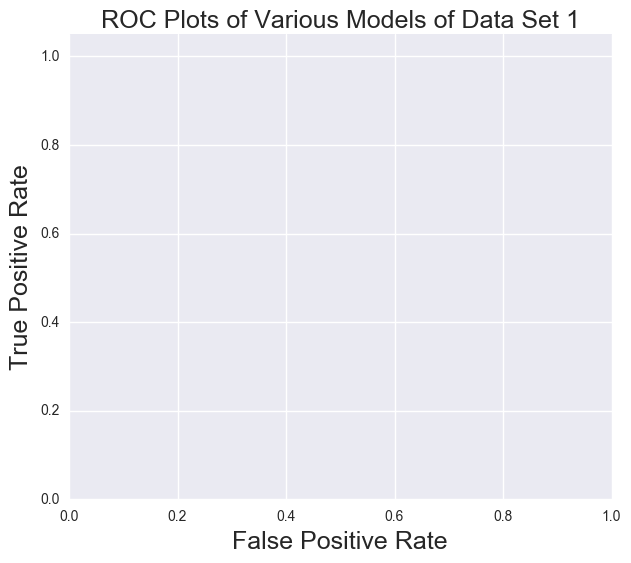

In [13]:
plt.figure(figsize=[7,6])
amounts = logreg.classes_
title = "ROC Plots of Various Models of Data Set 1".format(amounts[0], amounts[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title(title, fontsize=18)


FPR, TPR, _ = roc_curve(logregy_test1, [i[1] for i in cv_proba1], pos_label=logreg.classes_[1])
ROC_AUC = auc(FPR, TPR)
plt.plot(FPR, TPR, label='LogReg-1 ROC curve (area = %0.5f)' % ROC_AUC, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)

FPR3, TPR3, _ = roc_curve(knny_test1, [i[1] for i in knnproba1], pos_label=logreg.classes_[1])
ROC_AUC3 = auc(FPR3, TPR3)
plt.plot(FPR3, TPR3, label='KNN-1 ROC curve (area = %0.5f)' % ROC_AUC3, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)

FPR5, TPR5, _ = roc_curve(precy_test1, [i[1] for i in precprob1])
ROC_AUC5 = auc(FPR5, TPR5)
plt.plot(FPR5, TPR5, label='Average Precision Model 1 ROC curve (area = %0.5f)' % ROC_AUC5, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)

FPR6, TPR6, _ = roc_curve(treey_test1, [i[1] for i in tree_proba], pos_label=logreg.classes_[1])
ROC_AUC6 = auc(FPR6, TPR6)
plt.plot(FPR6, TPR6, label='Tree Classifier Model 1 ROC curve (area = %0.5f)' % ROC_AUC6, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)

FPR9, TPR9, _ = roc_curve(bagy_test1, [i[1] for i in bag_proba1], pos_label=logreg.classes_[1])
ROC_AUC9 = auc(FPR9, TPR9)
plt.plot(FPR9, TPR9, label='Bagging Model 1 ROC curve (area = %0.5f)' % ROC_AUC9, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)


plt.legend(loc="lower right")
plt.show()

NameError: name 'logregy_test2' is not defined

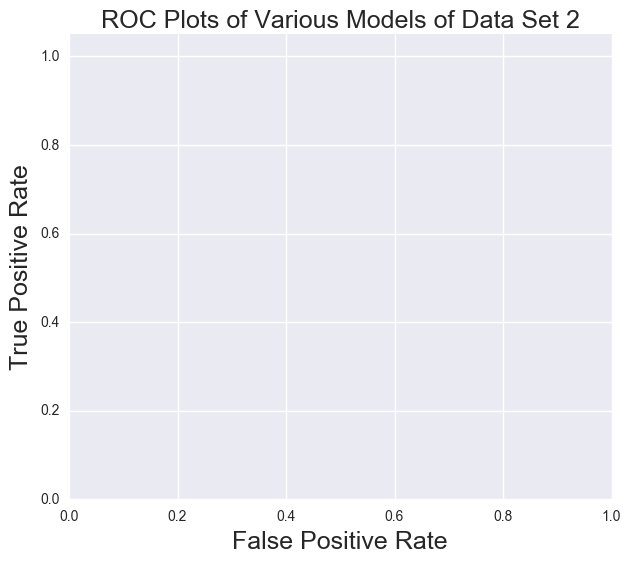

In [14]:
plt.figure(figsize=[7,6])
amounts = logreg.classes_
title = "ROC Plots of Various Models of Data Set 2".format(amounts[0], amounts[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title(title, fontsize=18)

lab=logreg.classes_[1]

FPR2, TPR2, _ = roc_curve(logregy_test2, [i[1] for i in cv_proba2],lab)
ROC_AUC2 = auc(FPR2, TPR2)
plt.plot(FPR2, TPR2, label='LogReg-2 ROC curve (area = %0.5f)' % ROC_AUC2, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)

FPR4, TPR4, _ = roc_curve(knny_test2, [i[1] for i in knnproba2],   lab)
ROC_AUC4 = auc(FPR4, TPR4)
plt.plot(FPR4, TPR4, label='KNN-2 ROC curve (area = %0.5f)' % ROC_AUC4, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)

FPR8, TPR8, _ = roc_curve(precy_test1, [i[1] for i in precprob2])
ROC_AUC8 = auc(FPR8, TPR8)
plt.plot(FPR8, TPR8, label='Average Precision Model 2 ROC curve (area = %0.5f)' % ROC_AUC8, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)

FPR7, TPR7, _ = roc_curve(treey_test2, [i[1] for i in tree_proba2],lab)
ROC_AUC7 = auc(FPR7, TPR7)
plt.plot(FPR7, TPR7, label='Tree Classifier Model 2 ROC curve (area = %0.5f)' % ROC_AUC7, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)

FPR10, TPR10, _ = roc_curve(bagy_test2, [i[1] for i in bag_proba2], pos_label=logreg.classes_[1])
ROC_AUC10 = auc(FPR10, TPR10)
plt.plot(FPR10, TPR10, label='Bagging Model 2 ROC curve (area = %0.5f)' % ROC_AUC10, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)

plt.legend(loc="lower right")
plt.show()

NameError: name 'bagy_test1' is not defined

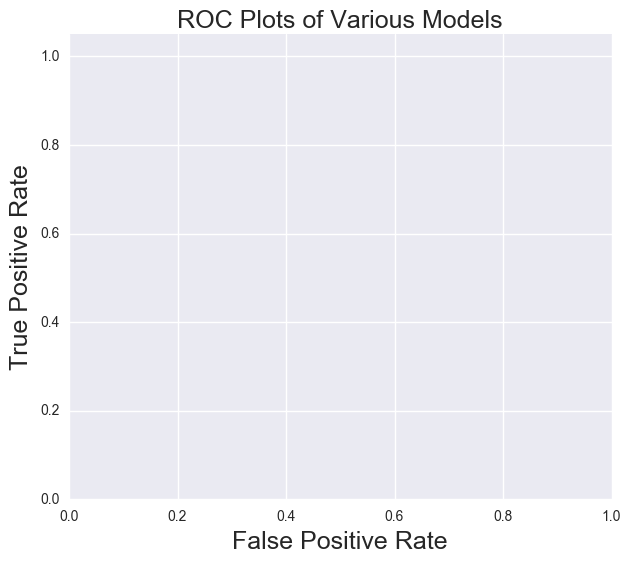

In [15]:
plt.figure(figsize=[7,6])
amounts = logreg.classes_
title = "ROC Plots of Various Models".format(amounts[0], amounts[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title(title, fontsize=18)

lab=logreg.classes_[1]

FPR9, TPR9, _ = roc_curve(bagy_test1, [i[1] for i in bag_proba1], pos_label=logreg.classes_[1])
ROC_AUC9 = auc(FPR9, TPR9)
plt.plot(FPR9, TPR9, label='Bagging Model 1 ROC curve (area = %0.5f)' % ROC_AUC9, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)

FPR10, TPR10, _ = roc_curve(bagy_test2, [i[1] for i in bag_proba2], pos_label=logreg.classes_[1])
ROC_AUC10 = auc(FPR10, TPR10)
plt.plot(FPR10, TPR10, label='Bagging Model 2 ROC curve (area = %0.5f)' % ROC_AUC10, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)

plt.legend(loc="lower right")
plt.show()